In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
import torch 
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import sys
# sys.path.insert(0, '/kaggle/input/dlproject')
from project_utilities import Loss
from project_utilities import ValueSet
from project_utilities import efficiency
train_set_idx, val_set_idx = train_test_split(list(range(1,80)), test_size=4)


In [ ]:
random_seed=132
learning_rate=0.001
num_epochs=5
b_size=128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.autograd.set_detect_anomaly(True)

In [ ]:
class MyDataset(torch.utils.data.Dataset): 
    def __init__(self, setID): 
        'Initialization' 
        npz_files_content = np.load("./drive/MyDrive/data/Set_"+str(setID)+".npz")  
         
        self.X_set = torch.tensor(npz_files_content['X'])    
        self.y_set = torch.tensor(npz_files_content['y']) 
    def __len__(self): 
        'Denotes the total number of samples' 
        return len(self.y_set) 
    def __getitem__(self, index): 
        'Generates one sample of data' 
        # Select sample 
        X = self.X_set[index] 
        y = self.y_set[index] 
        return X, y

In [ ]:
  
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential( 
                torch.nn.Conv1d(4, 1, stride=1, kernel_size=3, padding=1),
                )

    def forward(self, x):
       
        # x=x.view(128,4,4000)
       
        x = self.encoder(x)
       
        # x=x.view(128,4000)
        
        return x

model=CNN().to(device)
loss_model = Loss(0.00001)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [ ]:
def train(model, num_epochs, 
          learning_rate=0.01, seed=123, batch_size=128): 
    cost = [] 
     
    torch.manual_seed(seed) 
     
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
     
    for e in range(1,num_epochs): 
      batch_num = 0 
      for setID in train_set_idx: 
          train_set = MyDataset(setID+1) 
          train_generator = torch.utils.data.DataLoader(train_set,  
                                                        batch_size=batch_size,  
                                                        shuffle=True,drop_last =True) 
          print(setID) 
          for X_train, y_train in train_generator: 
            X_train=X_train.to(device)
            y_train=y_train.to(device)
            batch_num = batch_num + 1 
            #### Compute outputs #### 
            yhat = model(X_train) 
            loss = loss_model.forward(yhat, y_train) 
            #### Reset gradients from previous iteration #### 
            optimizer.zero_grad() 
             
            #### Compute gradients #### 
            loss.backward() 
             
            #### Update weights #### 
            optimizer.step() 
            #### Logging #### 
            with torch.no_grad(): 
                yhat = model.forward(X_train) 
                curr_loss = loss_model.forward(yhat, y_train) 
                print('Epoch ID: %d ' % e, end="") 
                print('  Set ID: %d' % setID, end="") 
                print('  Batch ID: %d' % batch_num, end="") 
                print(' | Loss: %.5f' % curr_loss) 
                cost.append(curr_loss) 
    return cost

In [ ]:
def validate(model): 
    loss_val = [] 
    b_size=5000
    eff = ValueSet(0, 0, 0, 0) 
    # switch to evaluate mode 
    model.eval() 
    with torch.no_grad():
        for setID in val_set_idx: 
          val_set = MyDataset(setID+1) 
          val_generator = torch.utils.data.DataLoader(val_set,  
                                                      batch_size=128,  
                                                      shuffle=True,drop_last=True) 
          print(setID) 
          for X_val, y_val in val_generator: 
            # Forward pass 
            X_val=X_val.to(device)
            y_val=y_val.to(device)
            val_outputs = model(X_val) 
            loss_output = loss_model.forward(val_outputs, y_val) 
            loss_val.append(loss_output) 
            for label, output in zip(y_val.cpu().numpy(), val_outputs.cpu().numpy()):
                eff += efficiency(label, output, difference = 5.0,  
                                  threshold = 1e-2, integral_threshold = 0.2,  
                                  min_width = 3) 
    return sum(loss_val)/len(loss_val), eff.eff_rate, eff.fp_rate

In [ ]:
Loss_train=[]
Loss_Validation=[]
Sample_Size=[5,10,15,20]
for i in range(len(Sample_Size)):
    
    model=CNN()
    model=model.to(device)    
    print("For Sample Size : ", Sample_Size[i])
#     b_size=512
    loss_model = Loss(0.00001)
    train_set_idx, val_set_idx = train_test_split(list(range(1,80)), test_size=Sample_Size[i])
    cost=train(model, num_epochs, seed=random_seed)
    Loss_train.append(float(cost[-1]))
    print("Train Loss : %0.3f" % float(cost[-1]))
    
    b_size=5000
    loss_val, eff_rate, fp_rate = validate(model) 
    print('Validation Loss: %0.3f ' % float(loss_val))
    Loss_Validation.append(float(loss_val))
    print()
    

Streaming output truncated to the last 5000 lines.
Epoch ID: 2   Set ID: 30  Batch ID: 2051 | Loss: 0.08881
Epoch ID: 2   Set ID: 30  Batch ID: 2052 | Loss: 0.09182
Epoch ID: 2   Set ID: 30  Batch ID: 2053 | Loss: 0.09720
Epoch ID: 2   Set ID: 30  Batch ID: 2054 | Loss: 0.10091
Epoch ID: 2   Set ID: 30  Batch ID: 2055 | Loss: 0.09207
Epoch ID: 2   Set ID: 30  Batch ID: 2056 | Loss: 0.09171
Epoch ID: 2   Set ID: 30  Batch ID: 2057 | Loss: 0.10045
Epoch ID: 2   Set ID: 30  Batch ID: 2058 | Loss: 0.09678
Epoch ID: 2   Set ID: 30  Batch ID: 2059 | Loss: 0.09748
Epoch ID: 2   Set ID: 30  Batch ID: 2060 | Loss: 0.09391
Epoch ID: 2   Set ID: 30  Batch ID: 2061 | Loss: 0.09261
Epoch ID: 2   Set ID: 30  Batch ID: 2062 | Loss: 0.09523
Epoch ID: 2   Set ID: 30  Batch ID: 2063 | Loss: 0.09424
Epoch ID: 2   Set ID: 30  Batch ID: 2064 | Loss: 0.09501
Epoch ID: 2   Set ID: 30  Batch ID: 2065 | Loss: 0.09448
Epoch ID: 2   Set ID: 30  Batch ID: 2066 | Loss: 0.09721
Epoch ID: 2   Set ID: 30  Batch ID: 2

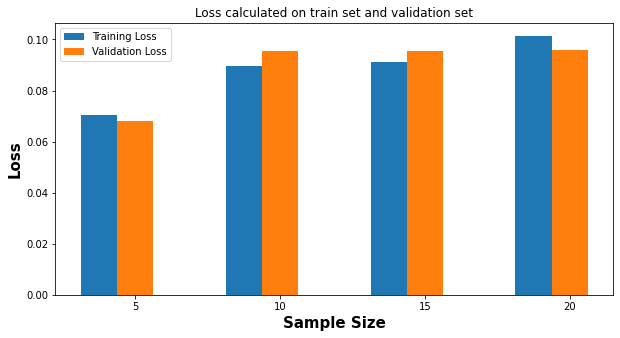

In [ ]:
import matplotlib.pyplot as plt
barWidth=0.25
fig = plt.subplots(figsize =(10,5))
bar1 = np.arange(4)
bar2 = [x + barWidth for x in bar1]

plt.bar(bar1, Loss_train, width = barWidth,label ='Training Loss')
plt.bar(bar2, Loss_Validation, width = barWidth, label ='Validation Loss')

plt.title('Loss calculated on train set and validation set')
plt.xlabel('Sample Size', fontweight ='bold', fontsize = 15)
plt.ylabel('Loss', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(4)],
        ['5','10','15','20'])
plt.legend()
plt.show()